Make sure that the tail part of the forward model applied to the (mock) observations is perfectly consistent with what happens within the main CosmoGrid forward model (both for fiducial and grid cosmologies)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, h5py
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices(device_type="GPU")[0], True)

os.environ["OMP_NUM_THREADS"] = str(len(os.sched_getaffinity(0)))
import healpy as hp

from msfm.fiducial_pipeline import FiducialPipeline
from msfm.utils import files, redshift, clustering, lensing, maps, observation

24-06-07 12:19:50   imports.py INF   Setting up healpy to run on 256 CPUs 
24-06-07 12:19:50   imports.py INF   Setting up healpy to run on 256 CPUs 
24-06-07 12:19:50   imports.py INF   Setting up healpy to run on 256 CPUs 
24-06-07 12:19:50   imports.py INF   Setting up healpy to run on 256 CPUs 


# select version

In [3]:
# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v8/linear_bias.yaml"
# tfr_pattern="/pscratch/sd/a/athomsen/DESY3/v8/linear_bias/tfrecords/fiducial/DESy3_fiducial_dmb_????.tfrecord",

conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v8/linear_bias_no_smoothing.yaml"
tfr_pattern="/pscratch/sd/a/athomsen/DESY3/v8/linear_bias_no_smoothing/tfrecords/fiducial/DESy3_fiducial_dmb_????.tfrecord",

# from .h5

In [4]:
conf = files.load_config(conf)

# pixels
n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]
data_vec_pix, patches_pix_dict, corresponding_pix_dict, _ = files.load_pixel_file(conf)
data_vec_len = len(data_vec_pix)

# fiducial values
Aia = conf["analysis"]["fiducial"]["Aia"]
n_Aia = conf["analysis"]["fiducial"]["n_Aia"]

bg = conf["analysis"]["fiducial"]["bg"]
n_bg = conf["analysis"]["fiducial"]["n_bg"]

# redshift dependence
z0 = conf["analysis"]["modelling"]["z0"]

metacal_bins = conf["survey"]["metacal"]["z_bins"]
tomo_z_metacal, tomo_nz_metacal = files.load_redshift_distributions("metacal", conf)
tomo_Aia = redshift.get_tomo_amplitudes(Aia, n_Aia, tomo_z_metacal, tomo_nz_metacal, z0)

maglim_bins = conf["survey"]["maglim"]["z_bins"]
tomo_z_maglim, tomo_nz_maglim = files.load_redshift_distributions("maglim", conf)
tomo_n_gal_maglim = np.array(conf["survey"]["maglim"]["n_gal"]) * hp.nside2pixarea(n_side, degrees=True)
tomo_bg = redshift.get_tomo_amplitudes(bg, n_bg, tomo_z_maglim, tomo_nz_maglim, z0)

n_z = len(metacal_bins) + len(maglim_bins)

# gnomview
x_deg = 10
y_deg = x_deg

x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

# for the rotated DES footprint
rot = (90, -30, 0)

hp_datapath = "/global/u2/a/athomsen/multiprobe-simulation-forward-model/data/healpy_data"

24-06-07 12:19:51     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 


### load the full sky maps

In [5]:
i_perm = 0

fidu_dir = "/global/cfs/cdirs/des/cosmogrid/v11desy3/fiducial/cosmo_fiducial"

with h5py.File(os.path.join(fidu_dir, f"perm_{i_perm:04d}", "projected_probes_maps_v11dmb.h5"), "r") as f:
    kg = []
    ia = []
    for z_bin in metacal_bins:
        kg.append(hp.ud_grade(f[f"kg/{z_bin}"], n_side))
        ia.append(hp.ud_grade(f[f"ia/{z_bin}"], n_side))
    kg = np.stack(kg, axis=-1)
    ia = np.stack(ia, axis=-1)

    # create the noiseless fiducial map
    wl_h5 = kg + tomo_Aia * ia

    dg = []
    for z_bin in maglim_bins:
        dg.append(hp.ud_grade(f[f"dg/{z_bin}"], n_side))
    dg = np.stack(dg, axis=-1)

    # create the noiseless fiducial map
    gc_h5 = clustering.galaxy_density_to_count(tomo_n_gal_maglim, dg/np.mean(dg), tomo_bg, nest=False)

print(wl_h5.shape)
print(gc_h5.shape)

h5_original = np.concatenate([wl_h5, gc_h5], axis=-1)

(3145728, 4)
(3145728, 4)


# from .tfrecord

In [6]:
fidu_pipe = FiducialPipeline(
    conf=conf,
    params=[],
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=False,
    apply_m_bias=False,
    shape_noise_scale=0.0,
    poisson_noise_scale=0.0,
)

24-06-07 12:20:56     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-06-07 12:20:56     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 


In [7]:
fidu_dset = fidu_pipe.get_dset(
    tfr_pattern=tfr_pattern,
    local_batch_size=1,
    noise_indices=10,
    n_readers=1,
    examples_shuffle_buffer=None,
    n_prefetch=None,
    is_eval=True,
)

for dv, index in fidu_dset.take(1):
    i_example = index[0].numpy()
    i_noise = index[1].numpy()

    print(f"i_example = {i_example}, i_noise = {i_noise}")

print(dv.shape)

24-06-07 12:20:57 fiducial_pip WAR   Evaluation mode is activated: the random seed is fixed, the shuffle arguments ignored, and the dataset is not repeated 
24-06-07 12:20:57 fiducial_pip INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-06-07 12:20:57 fiducial_pip INF   drop_remainder is not set, using drop_remainder = False 
24-06-07 12:20:57 fiducial_pip INF   Including noise_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 
24-06-07 12:20:57 fiducial_pip INF   Interleaving with n_readers = 1 
24-06-07 12:20:58 fiducial_pip INF   Batching into 1 elements locally with drop_remainder = False 
24-06-07 12:20:58 fiducial_pip WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warnin

# forward model the .h5 as an observation

### weak lensing

In [8]:
kappa2gamma_fac, gamma2kappa_fac, _ = lensing.get_kaiser_squires_factors(3*n_side-1)

# wl_h5_obs = np.zeros((data_vec_len, 4))
gamma1 = []
gamma2 = []
for i in range(4):
    # kappa -> gamma (full sky)
    kappa_alm = hp.map2alm(
        wl_h5[:,i],
        use_pixel_weights=True,
        datapath=hp_datapath,
    )

    gamma_alm = kappa_alm * kappa2gamma_fac
    _, gamma1_full, gamma2_full = hp.alm2map(
        [np.zeros_like(gamma_alm), gamma_alm, np.zeros_like(gamma_alm)], nside=n_side
    )
    
    patch_pix = patches_pix_dict["metacal"][i][0]
    gamma1_patch = np.zeros(n_pix, dtype=np.float32)
    gamma1_patch[patch_pix] = gamma1_full[patch_pix]

    gamma2_patch = np.zeros(n_pix, dtype=np.float32)
    gamma2_patch[patch_pix] = gamma2_full[patch_pix]


    gamma1.append(gamma1_patch)
    gamma2.append(gamma2_patch)
    
gamma1 = np.stack(gamma1, axis=-1)
gamma2 = np.stack(gamma2, axis=-1)

h5_wl_gamma_map = np.stack([gamma1, gamma2], axis=-1)

### galaxy clustering

In [9]:
# patch_pix = patches_pix_dict["maglim"][0]
# maglim_mask = files.get_tomo_dv_masks(conf)["maglim"]

# dg_patch = np.zeros_like(dg)

# # cut out the footprint
# dg_patch[patch_pix] = dg[patch_pix]

# # subtract and divide by mean (within the patch)
# dg_patch[patch_pix] = (dg_patch[patch_pix] - np.mean(dg_patch[patch_pix])) / np.mean(dg_patch[patch_pix])

# # density contrast to count
# h5_gc_count_map = clustering.galaxy_density_to_count(
#     tomo_n_gal_maglim, 
#     dg_patch, 
#     tomo_bg, 
#     conf=conf, 
#     nest=False,
# )

In [10]:
patch_pix = patches_pix_dict["maglim"][0]
maglim_mask = files.get_tomo_dv_masks(conf)["maglim"]

dg_patch = np.zeros_like(dg)

# cut out the footprint
dg_patch[patch_pix] = dg[patch_pix]

# subtract and divide by mean (within the patch)
dg_patch[patch_pix] = (dg_patch[patch_pix] - np.mean(dg_patch[patch_pix])) / np.mean(dg_patch[patch_pix])

dg_patch = maps.tomographic_reorder(dg_patch, r2n=True)
dg_dv = dg_patch[data_vec_pix]

# density contrast to count
h5_gc_count_dv = clustering.galaxy_density_to_count(
    tomo_n_gal_maglim, 
    dg_dv, 
    tomo_bg, 
    conf=conf, 
    mask=maglim_mask,
    nest=True,
)

h5_gc_count_map = np.zeros((n_pix,4))
h5_gc_count_map[data_vec_pix] = h5_gc_count_dv
h5_gc_count_map = maps.tomographic_reorder(h5_gc_count_map, n2r=True)

24-06-07 12:21:09     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 


### forward model the (CosmoGrid internal mock) observation

In [11]:
h5_obs = observation.forward_model_observation_map(
    wl_gamma_map=h5_wl_gamma_map,
    gc_count_map=h5_gc_count_map,
    conf=conf,
    apply_norm=False,
    with_padding=True,
    nest=False,
)

24-06-07 12:21:10     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-06-07 12:21:10     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 


# comparison

In [12]:
# .tfrecord
tf_map = np.zeros((n_pix, n_z))
tf_map[data_vec_pix] = dv[0]

# original .h5
h5_original_map = maps.tomographic_reorder(h5_original.copy(), r2n=True)

# forward modeled .h5
h5_obs_map = np.zeros((n_pix, n_z))
h5_obs_map[data_vec_pix] = h5_obs

# differences
without_obs_fm = tf_map - h5_original_map
with_obs_fm = tf_map - h5_obs_map

### weak lensing

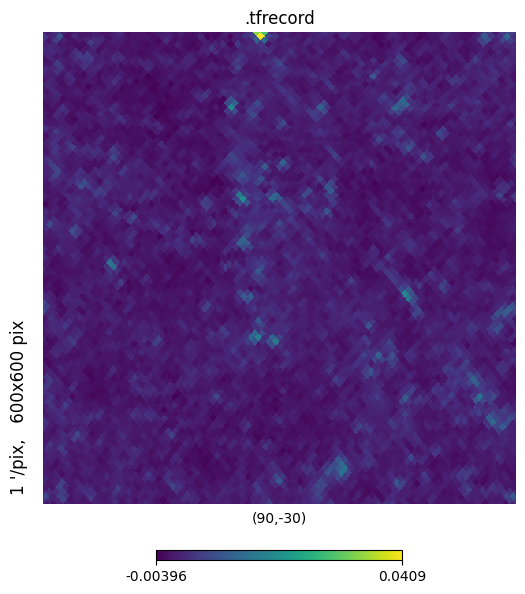

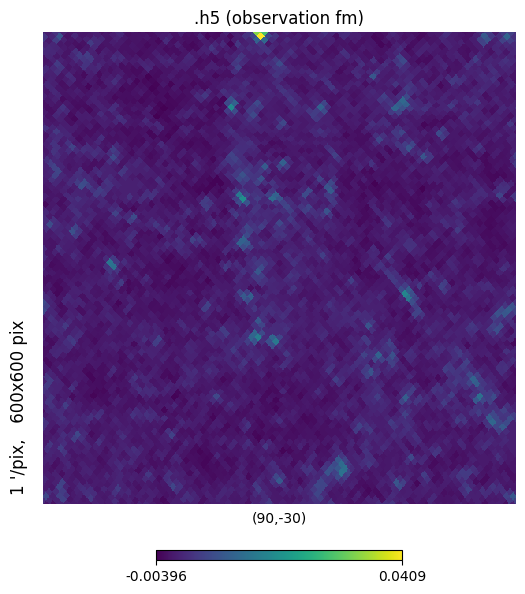

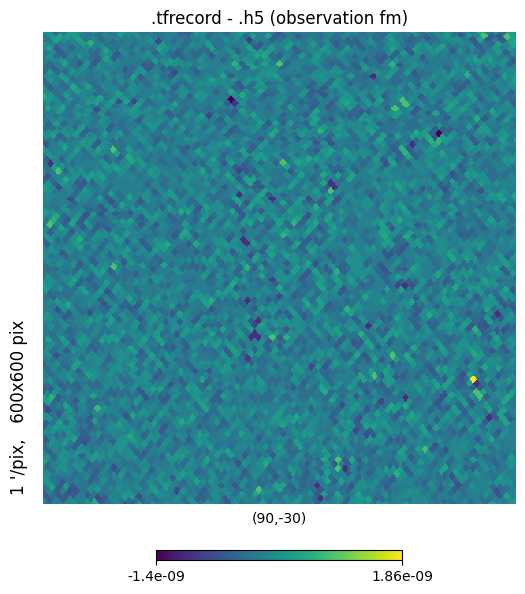

In [13]:
# weak lensing in [0,1,2,3], galaxy clustering in [4,5,6,7]
i_z = 0

# .tfrecord
hp.gnomview(tf_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord")

# forward modeled .h5
hp.gnomview(h5_obs_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (observation fm)")

# differences
hp.gnomview(with_obs_fm[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (observation fm)")

# original .h5
# hp.gnomview(h5_original_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (original)")
# hp.gnomview(without_obs_fm[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (original)")

### galaxy clustering

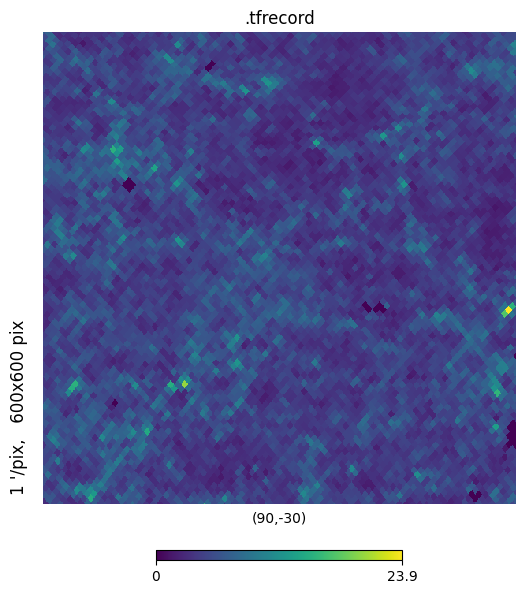

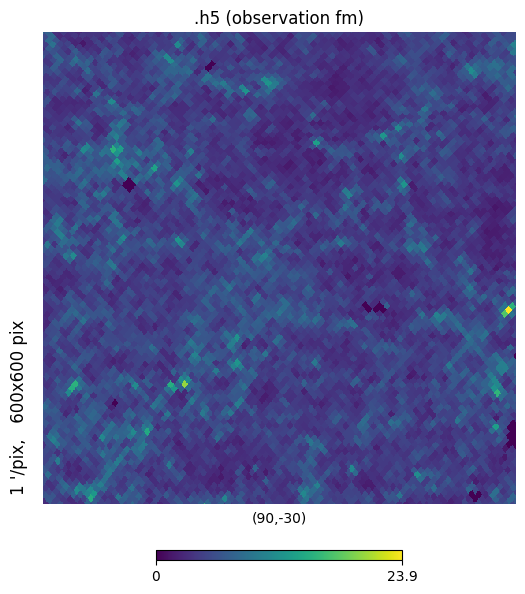

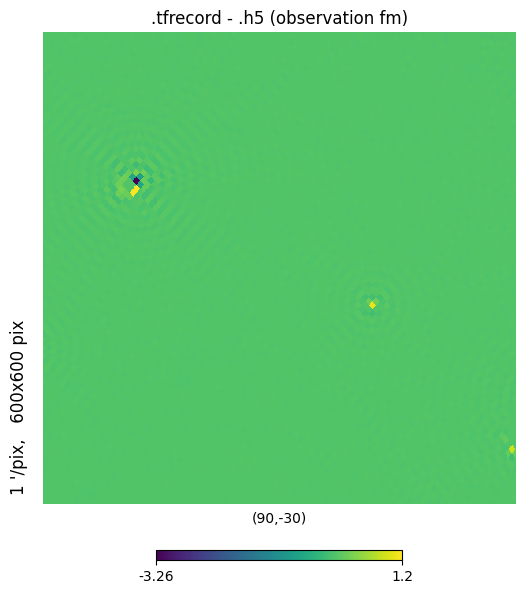

In [14]:
# weak lensing in [0,1,2,3], galaxy clustering in [4,5,6,7]
i_z = 5

# .tfrecord
hp.gnomview(tf_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord")

# forward modeled .h5
hp.gnomview(h5_obs_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (observation fm)")

# differences
hp.gnomview(with_obs_fm[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (observation fm)")

# # original .h5
# hp.gnomview(h5_original_map[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".h5 (original)")
# # hp.gnomview(without_obs_fm[:,i_z], nest=True, rot=rot, reso=reso, xsize=x_pix, ysize=y_pix, title=".tfrecord - .h5 (original)")